In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from inline_tensorboard import show_graph
from IPython.display import Image

In [2]:
sess = tf.InteractiveSession()

# Generate Data
Let's regenerate the same dataset.

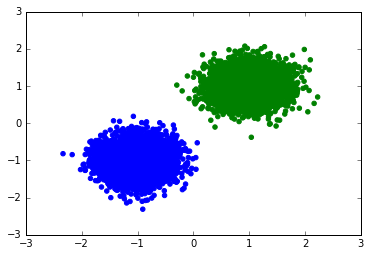

In [3]:
x11, x12 = np.random.multivariate_normal([1, 1], 0.1 * np.eye(2), 5000).T
x21, x22 = np.random.multivariate_normal([-1, -1], 0.1 * np.eye(2), 5000).T

x_ = np.array([np.concatenate([x11, x21]),
              np.concatenate([x12, x22])]).T
y_ = np.array([0] * 5000 + [1] * 5000)

plt.scatter(x_[:,0], x_[:,1], color=['g'] * 5000 + ['b'] * 5000)
plt.show()

# Variable scope
Hard to manage variables in large models -- often you want to have two copies of the same model, how do you reuse the same model without having to rename all the variables manually?

In [4]:
with tf.variable_scope('foo'):
    bar = tf.get_variable("bar", shape=tf.TensorShape([]), dtype=tf.float32)

In [5]:
for var in tf.global_variables():
    print var

<tf.Variable 'foo/bar:0' shape=() dtype=float32_ref>


# Practical example: 2-layer Neural Network

$h_1 = W_1 x + b $  
$h_2 = W_1 h_1 + b $

where  
$x \in \mathbb{R}^n$,  
$W_1 \in \mathbb{R}^{n \times m}$ and $b_1 \in \mathbb{R}^m$  
$W_2 \in \mathbb{R}^{m \times p}$ and $b_2 \in \mathbb{R}^p$

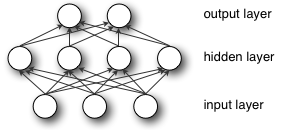

In [6]:
Image('./images/mlp.png')

In [7]:
class FullyConnectedLayer:
    def __init__(self, n_in, n_out):
        initializer = tf.random_uniform_initializer(minval=-np.sqrt(3), maxval=np.sqrt(3))
        
        self.W = tf.get_variable("Weight",
                                 shape=tf.TensorShape([n_in, n_out]),
                                 initializer=initializer,
                                 dtype=tf.float32)

        self.b = tf.get_variable("bias",
                                 shape=tf.TensorShape([n_out]),
                                 initializer=initializer,
                                 dtype=tf.float32)
        
    def get_result(self, x):
        return tf.nn.sigmoid(tf.matmul(x, self.W) + self.b)

**Type 1:** Not sharing weights  
$W_1 \neq W_2$, $b_1 \neq b_2$

In [8]:
input_ = tf.placeholder(tf.float32, shape=tf.TensorShape([None, 2]), name="input")

with tf.variable_scope('layer_1'):
    fcn1 = FullyConnectedLayer(2, 2)
    h1   = fcn1.get_result(input_)

with tf.variable_scope('layer_2'):
    fcn2 = FullyConnectedLayer(2, 1)
    h2   = fcn2.get_result(h1)

In [9]:
tf.global_variables_initializer().run()

In [10]:
# Construct a "batch" of inputs
batch_indices = np.random.randint(0, 10000, size=64)

placeholder_values = {
    input_: x_[batch_indices]
}

In [11]:
print 'Shape of input:  ', np.shape(x_[batch_indices])
print 'Shape of layer 1:', np.shape(h1.eval(placeholder_values))
print 'Shape of layer 2:', np.shape(h2.eval(placeholder_values))

Shape of input:   (64, 2)
Shape of layer 1: (64, 2)
Shape of layer 2: (64, 1)


**Type 2:** Sharing weights  
$W_1 = W_2$, $b_1 = b_2$

In [12]:
with tf.variable_scope('unified') as scope:
    fcn1 = FullyConnectedLayer(2, 2)
    h1   = fcn1.get_result(input_)
    scope.reuse_variables()
    fcn2 = FullyConnectedLayer(2, 2)
    h2   = fcn2.get_result(h1)

In [13]:
tf.global_variables_initializer().run()

In [14]:
print 'Shape of input:  ', np.shape(x_[batch_indices])
print 'Shape of layer 1:', np.shape(h1.eval(placeholder_values))
print 'Shape of layer 2:', np.shape(h2.eval(placeholder_values))

Shape of input:   (64, 2)
Shape of layer 1: (64, 2)
Shape of layer 2: (64, 2)
